In [1]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import os
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import yaml

In [2]:
##################################################################
# parameters
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# parameters
image_size = config['parameters']['image_size']
total_steps = config['parameters']['total_steps']
learning_rate = config['parameters']['learning_rate']
alpha = config['parameters']['alpha']
beta = config['parameters']['beta']

# path e image
folder_img_original = config['path']['folder_img_original']
folder_img_style = config['path']['folder_img_style']
folder_img_generated = config['path']['folder_img_generated']
name_img_original = config['path']['name_img_original']
name_img_style = config['path']['name_img_style']
name_img_generated = config['path']['name_img_generated']

# creo percorso immagini
path_img_original = os.path.join(folder_img_original, name_img_original)
path_img_style = os.path.join(folder_img_style, name_img_style)
path_img_generated = os.path.join(folder_img_generated, name_img_generated)

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(weights = models.VGG19_Weights.DEFAULT).features[:29]
        
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
                
        return features

In [12]:
## Questo funziona!!!!!!!! Per ora lasciare cosi

# # carico le immagini

device = torch.device("cpu")

# loader = transforms.Compose(
#     [
#         transforms.Resize((image_size, image_size)),
#         transforms.ToTensor(),
#     ]
# )

# def load_image(image_name):
#     image = Image.open(image_name)
#     image = loader(image).unsqueeze(0)
#     return image.to(device, torch.float)


# # carico immagine originale
# original_img = load_image(path_img_original)

# # carico immagine con lo stile richiesto
# style_img = load_image(path_img_style)

# #generated = torch.randn(original_img.shape, device = device, requires_grad = True)
generated = original_img.clone().requires_grad_(True)

In [5]:
# creo una funzione per visualizzare le immagini caricate

unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()  # modalità interattiva per visualizzare i plot
# plt.ioff() # chuido modalità interattiva


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# # visualizzo le immagini
# plt.figure()
# imshow(style_img, title='Style Image')

# plt.figure()
# imshow(original_img, title='Content Image')

In [6]:
from torchvision import transforms
from PIL import Image


device = torch.device("cpu")


# Funzione per caricare l'immagine e convertirla in un tensore
def load_image(image_name):
    loader = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

# Funzione per normalizzare un tensore
def normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    return (tensor - mean) / std

# Denormalizza l'immagine
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)  # I valori potrebbero essere leggermente fuori dal range [0,1] a causa di piccoli errori numerici, quindi li limitiamo.
    
    return tensor

# Carica l'immagine
original_img = load_image(path_img_original)
style_img = load_image(path_img_style)

# Normalizza le immagini
original_img_normalized = normalize(original_img)
style_img_normalized = normalize(style_img)

# Denormalizza le immagini
original_img_denormalized = denormalize(original_img_normalized)
style_img_denormalized = denormalize(style_img_normalized)

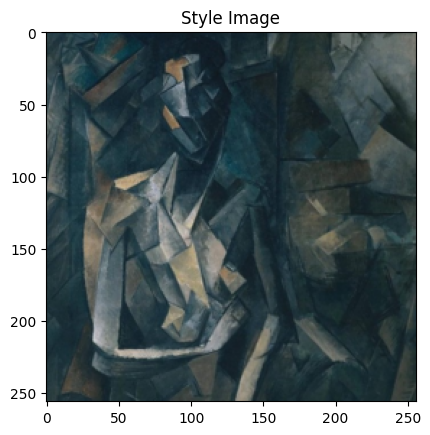

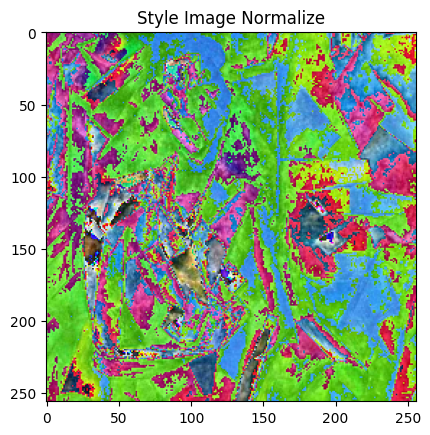

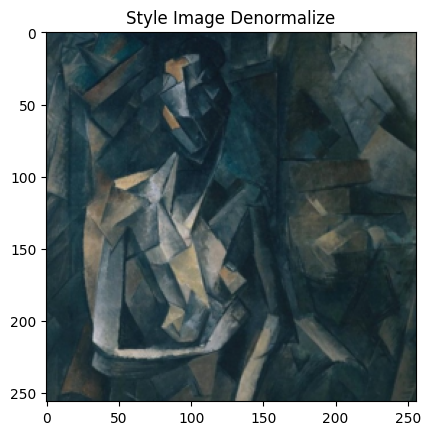

In [7]:
# visualizzo le immagini
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(style_img_normalized, title='Style Image Normalize')

plt.figure()
imshow(style_img_denormalized, title='Style Image Denormalize')

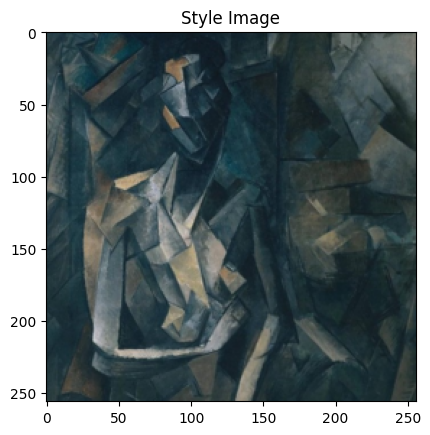

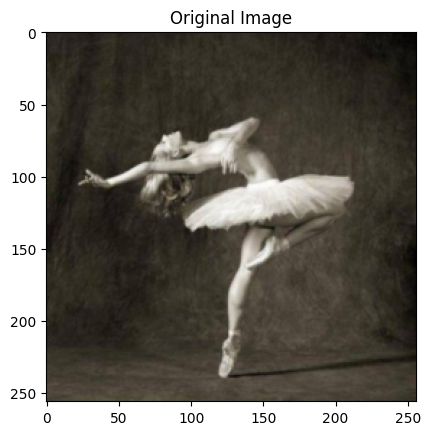

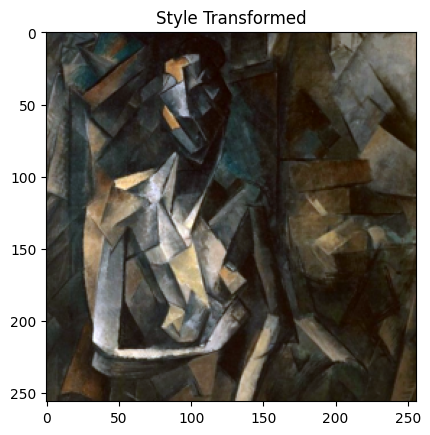

In [11]:
def compute_mean_std(image):
    mean = image.mean([2, 3])
    std = image.std([2, 3])
    return mean, std

def color_transfer(source, target):
    source_mean, source_std = compute_mean_std(source)
    target_mean, target_std = compute_mean_std(target)

    # Aggiungi dimensioni extra a mean e std
    source_mean = source_mean.unsqueeze(-1).unsqueeze(-1)
    source_std = source_std.unsqueeze(-1).unsqueeze(-1)
    target_mean = target_mean.unsqueeze(-1).unsqueeze(-1)
    target_std = target_std.unsqueeze(-1).unsqueeze(-1)

    result = (source - source_mean) / source_std
    result = result * target_std + target_mean
    return result

# Applica il trasferimento del colore, ma le immagini devono essere normalizzate!!!
style_img_transformed_normalized = color_transfer(style_img_normalized, original_img_normalized)  # trasferisce colore da original_img a style_img

# denormalizzo immagine
style_img_transformed_denormalized = denormalize(style_img_transformed_normalized)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title='Original Image')
# imshow(style_img_transformed_normalized, title='Style Image Transformed Normalized')

plt.figure()
imshow(style_img_transformed_denormalized, title='Style Transformed')


In [13]:
# creo immagine di input
generated = original_img.clone().requires_grad_(True)

In [14]:
# fin qui posso essere soddisfatto, anche se il traferimento del colore non è il massimo e dovrei testarlo su altre immagini

# cose da fare:
# 1. Sistemare la parte di ottimizzazione del modello
# 2. Creare una funzione train() stile articolo con il professore
# 3. Denormalizzare il risultato ottenuto, visualizzarlo e infine salvarlo!
# 4. Eseguire alcuni test
# 5. Una volta soddisfatti, creare un file READ ME (chat gpt) e caricarlo su git-hub 
# 6. Condividere il progetto su datapizza.tech e instagram

# Extra: migliorare il trasferimento del colore con i tentativi presenti nell'articolo selezionato

In [15]:
# definisco il modello
model = VGG().to(device).eval()

optimizer = optim.Adam([generated], lr = learning_rate)

for step in range(total_steps):
    generated_features = model(generated)
    original_img_features = model(original_img_normalized)
    style_features = model(style_img_transformed_normalized)
    
    style_loss = original_loss = 0
    
    for gen_feature, orig_feature, style_feature in zip(generated_features, original_img_features, style_features):
        batch_size, channel, height, width = gen_feature.shape
        original_loss = torch.mean((gen_feature - orig_feature) **2)
        
        #compute the Gram Matrix
        G = gen_feature.view(channel, height*width).mm(
            gen_feature.view(channel, height*width).t()
        )
        
        A = style_feature.view(channel, height*width).mm(
            style_feature.view(channel, height*width).t()
        )
        
        style_loss += torch.mean((G-A)**2)
        
    total_loss = alpha*original_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 5 == 0:
        print("Step: {}, Original Loss: {:4f}, Style Loss: {:4f}, Total Loss: {:4f}".format(step, original_loss.detach().numpy(), style_loss.detach().numpy(), total_loss.detach().numpy()))

# Converte il tensore PyTorch in un array NumPy
generated_numpy = generated.cpu().detach().numpy()
generated_numpy = generated_numpy.squeeze()  # Rimuove la dimensione 1
generated_numpy = generated_numpy.astype('uint8')
image = Image.fromarray(generated_numpy.transpose(1, 2, 0))  # Cambia l'ordine delle dimensioni se necessario

KeyboardInterrupt: 

In [ ]:
# visualizza immagine

# denormalizzo il risultato
generated_denormalized = denormalize(generated)

# visualizzo immagine finale
plt.figure()
imshow(generated_denormalized, title="Neural Transfer Learning's Output")

In [ ]:
# salva immagine
# Salva l'immagine come file .png
image.save(path_img_generated)

In [ ]:
# prossimi step:

# 1) far funzionare il codice (ok)
# 2) creare file yaml per la scelta delle immagini!
# 3) provare a modificare il codice con chat gpt
# 4) usare articolo dei colori + chat gpt per mantenere i colori della foto originale anche all'immagine generata